<a href="https://colab.research.google.com/github/TracyMabaso/LAB07_BICT332/blob/main/LAB07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
pip install numpy pandas matplotlib scikit-learn

In [66]:
# 1.2: Import libraries and define majority vote classifier
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """A majority vote ensemble classifier"""

    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {f"clf_{i}": clf for i, clf in enumerate(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = [clone(clf).fit(X, self.lablenc_.transform(y)) for clf in self.classifiers]
        return self

    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(
                lambda x: np.argmax(np.bincount(x, weights=self.weights)),
                axis=1, arr=predictions)
        return self.lablenc_.inverse_transform(maj_vote)

    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        return np.average(probas, axis=0, weights=self.weights)

    def get_params(self, deep=True):
        if not deep:
            return super().get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out[f'{name}__{key}'] = value
            return out


In [67]:
# 1.3: Load and prepare dataset
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
y = LabelEncoder().fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)


In [68]:
# 1.4: Create classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=1, max_iter=500)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

pipe1 = Pipeline([('sc', StandardScaler()), ('clf', clf1)])
pipe3 = Pipeline([('sc', StandardScaler()), ('clf', clf3)])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='roc_auc')
    print(f"ROC AUC: {scores.mean():.2f} (+/- {scores.std():.2f}) [{label}]")


10-fold cross validation:

ROC AUC: 0.94 (+/- 0.07) [Logistic regression]
ROC AUC: 0.90 (+/- 0.12) [Decision tree]
ROC AUC: 0.86 (+/- 0.12) [KNN]


In [69]:
# 1.5: Create and Evaluate Majority Voting Classifier
from sklearn.model_selection import cross_val_score

# Create majority vote classifier
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3], vote='classlabel')
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

print('10-fold cross validation:\n')

# Use accuracy instead of roc_auc to avoid errors
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='accuracy')
    print(f"Accuracy: {scores.mean():.2f} (+/- {scores.std():.2f}) [{label}]")


10-fold cross validation:

Accuracy: 0.61 (+/- 0.13) [Logistic regression]
Accuracy: 0.90 (+/- 0.11) [Decision tree]
Accuracy: 0.86 (+/- 0.13) [KNN]
Accuracy: 0.89 (+/- 0.11) [Majority voting]


In [70]:
# 2.2: Load Wine dataset
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash',
                   'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols',
                   'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']

df_wine = df_wine[df_wine['Class label'] != 1]
y = LabelEncoder().fit_transform(df_wine['Class label'].values)
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)


In [71]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

# Decision tree
tree = DecisionTreeClassifier(criterion='entropy', random_state=1)

# Bagging classifier (updated argument)
bag = BaggingClassifier(estimator=tree, n_estimators=500,
                        max_samples=1.0, max_features=1.0,
                        bootstrap=True, n_jobs=-1, random_state=1)

# Train classifiers
tree.fit(X_train, y_train)
bag.fit(X_train, y_train)

# Evaluate
for clf, label in zip([tree, bag], ['Decision tree', 'Bagging']):
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    print(f'{label} train/test accuracies: {accuracy_score(y_train, y_train_pred):.3f}/{accuracy_score(y_test, y_test_pred):.3f}')


Decision tree train/test accuracies: 1.000/0.833
Bagging train/test accuracies: 1.000/0.917


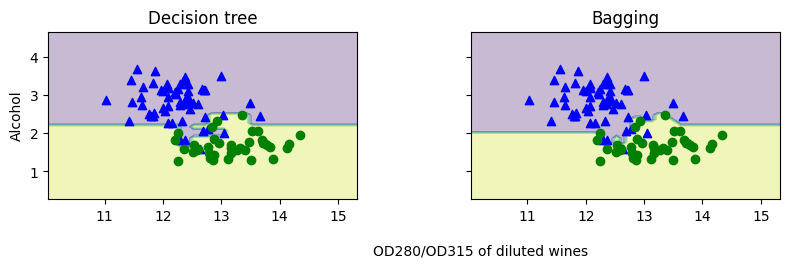

In [72]:
import matplotlib.pyplot as plt

x_min, x_max = X_train[:,0].min()-1, X_train[:,0].max()+1
y_min, y_max = X_train[:,1].min()-1, X_train[:,1].max()+1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8,3))
for idx, clf, tt in zip([0,1],[tree,bag],['Decision tree','Bagging']):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0,0], X_train[y_train==0,1], c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train==1,0], X_train[y_train==1,1], c='green', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol')
plt.text(10.2, -1.2, 'OD280/OD315 of diluted wines', ha='center')
plt.tight_layout()
plt.show()


In [73]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Decision tree stump
tree = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=1)

# Correct AdaBoost syntax for sklearn >=1.2
ada = AdaBoostClassifier(estimator=tree, n_estimators=500, learning_rate=0.1, random_state=1)

# Train and evaluate decision tree stump
tree.fit(X_train, y_train)
y_train_pred_tree = tree.predict(X_train)
y_test_pred_tree = tree.predict(X_test)
print(f'Decision tree stump train/test: {accuracy_score(y_train, y_train_pred_tree):.3f}/{accuracy_score(y_test, y_test_pred_tree):.3f}')

# Train and evaluate AdaBoost
ada.fit(X_train, y_train)
y_train_pred_ada = ada.predict(X_train)
y_test_pred_ada = ada.predict(X_test)
print(f'AdaBoost train/test: {accuracy_score(y_train, y_train_pred_ada):.3f}/{accuracy_score(y_test, y_test_pred_ada):.3f}')


Decision tree stump train/test: 0.916/0.875
AdaBoost train/test: 0.968/0.917


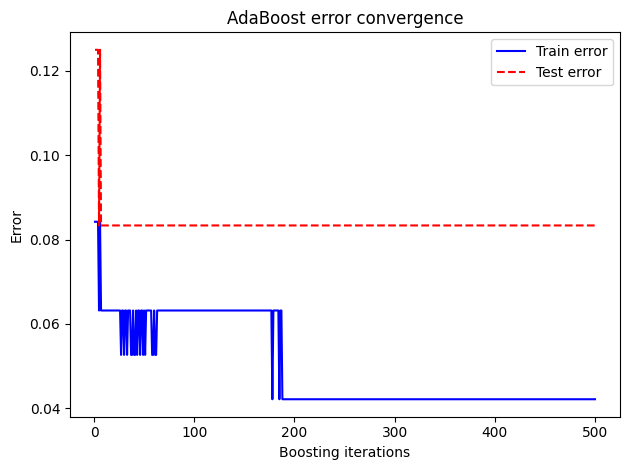

In [74]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Create AdaBoost classifier with decision stump
ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=1),
    n_estimators=500,
    learning_rate=0.1,
    random_state=1
)

# Fit AdaBoost
ada.fit(X_train, y_train)

# Calculate staged error for train and test
ada_train_err = [1 - accuracy_score(y_train, y_pred) for y_pred in ada.staged_predict(X_train)]
ada_test_err = [1 - accuracy_score(y_test, y_pred) for y_pred in ada.staged_predict(X_test)]

# Plot error convergence
plt.plot(range(1, len(ada_train_err)+1), ada_train_err, label='Train error', color='blue')
plt.plot(range(1, len(ada_test_err)+1), ada_test_err, label='Test error', color='red', linestyle='--')
plt.xlabel('Boosting iterations')
plt.ylabel('Error')
plt.legend()
plt.title('AdaBoost error convergence')
plt.tight_layout()
plt.show()


In [75]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, AdaBoostClassifier
import pandas as pd

# Load Iris dataset
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# Create individual classifiers
clf_lr = LogisticRegression(random_state=1, max_iter=500)
clf_knn = KNeighborsClassifier()
clf_dt = DecisionTreeClassifier(random_state=1)
clf_rf = RandomForestClassifier(random_state=1)

# Create ensemble classifiers
voting_clf = VotingClassifier(estimators=[('lr', clf_lr), ('knn', clf_knn), ('dt', clf_dt), ('rf', clf_rf)], voting='hard')

# Updated for scikit-learn 1.2+: 'estimator' instead of 'base_estimator'
bagging_clf = BaggingClassifier(estimator=clf_dt, n_estimators=100, random_state=1)
adaboost_clf = AdaBoostClassifier(estimator=clf_dt, n_estimators=100, random_state=1)

# List of classifiers
classifiers = [clf_lr, clf_knn, clf_dt, clf_rf, voting_clf, bagging_clf, adaboost_clf]
classifier_names = ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'Voting Classifier', 'Bagging', 'AdaBoost']

# Evaluate all classifiers using 10-fold cross-validation
results = []
for clf, name in zip(classifiers, classifier_names):
    scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
    results.append({
        'Classifier': name,
        'Mean Accuracy': scores.mean(),
        'Std Accuracy': scores.std()
    })

# Display results sorted by accuracy
results_df = pd.DataFrame(results).sort_values('Mean Accuracy', ascending=False)
print(results_df)


            Classifier  Mean Accuracy  Std Accuracy
1                  KNN       0.951818      0.048285
0  Logistic Regression       0.941818      0.047621
4    Voting Classifier       0.940909      0.065839
5              Bagging       0.940909      0.065839
3        Random Forest       0.931818      0.063278
2        Decision Tree       0.922727      0.059231
6             AdaBoost       0.922727      0.071841


In [76]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# AdaBoost GridSearch
param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0],
    'estimator__max_depth': [1, 2, 3]  # updated key
}

ada_clf = AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=1), random_state=1)
gs_ada = GridSearchCV(ada_clf, param_grid_ada, cv=5, scoring='accuracy', n_jobs=-1)
gs_ada.fit(X_train, y_train)

print("AdaBoost Best params:", gs_ada.best_params_)
print("AdaBoost Best score:", gs_ada.best_score_)

# Bagging GridSearch
param_grid_bag = {
    'n_estimators': [50, 100, 200],
    'max_samples': [0.5, 0.8, 1.0],
    'max_features': [0.5, 0.8, 1.0]
}

bag_clf = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=1), random_state=1)
gs_bag = GridSearchCV(bag_clf, param_grid_bag, cv=5, scoring='accuracy', n_jobs=-1)
gs_bag.fit(X_train, y_train)

print("Bagging Best params:", gs_bag.best_params_)
print("Bagging Best score:", gs_bag.best_score_)


AdaBoost Best params: {'estimator__max_depth': 1, 'learning_rate': 0.1, 'n_estimators': 50}
AdaBoost Best score: 0.9714285714285713
Bagging Best params: {'max_features': 0.8, 'max_samples': 0.5, 'n_estimators': 200}
Bagging Best score: 0.9523809523809523
